# Cyber Insurance Analytics

## Module 1 Simulator code

In [ ]:
import scipy
from scipy import stats
from scipy.stats import beta
import numpy as np
import random

In [ ]:
def beta_simulator(x):
    minimum = x[0]
    mode = x[1]
    maximum = x[2]
    conf = x[3]
    if conf=='low':
        d = (minimum + mode + 4*maximum)/6
    elif conf=='medium':
        d = (minimum + 4*mode + maximum)/6
    else:
        d = (4*minimum + mode + maximum)/6
    alpha = 6*((d - minimum)/(maximum - minimum))
    beta = 6*((maximum - d)/(maximum - minimum))
    location = minimum
    scale = maximum - minimum
    return scipy.stats.beta.ppf(np.random.rand(), alpha, beta, location, scale)

In [ ]:
tef = [2,5,20,'medium']
difficulty = [70,90,95,'high']
tcap = [80,85,90,'low']

In [ ]:
n = 10000
lef = []
for i in range(0,n+1):
    if(beta_simulator(tcap) > beta_simulator(difficulty)):
        lef.append(beta_simulator(tef))
    else:
        lef.append(0)

In [ ]:
sum(lef)/n

6.812547859651061

## Modelling Intrusion Detection: Analysis of a Feature Selection Mechanism


### Step 1: Data preprocessing:
All features are made numerical using one-Hot-encoding. The features are scaled to avoid features with large values that may weigh too much in the results.

### Step 2: Feature Selection:
Eliminate redundant and irrelevant data by selecting a subset of relevant features that fully represents the given problem.
Univariate feature selection with ANOVA F-test. This analyzes each feature individually to detemine the strength of the relationship between the feature and labels. Using SecondPercentile method (sklearn.feature_selection) to select features based on percentile of the highest scores. 
When this subset is found: Recursive Feature Elimination (RFE) is applied.

### Step 4: Build the model:
Decision tree model is built.

### Step 5: Prediction & Evaluation (validation):
Using the test data to make predictions of the model.
Multiple scores are considered such as:accuracy score, recall, f-measure, confusion matrix.
perform a 10-fold cross-validation.

## Version Check

In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

0.19.2
1.11.3
3.6.0 |Anaconda 4.3.0 (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC v.1900 64 bit (AMD64)]
0.18.1


## Load the Dataset

In [ ]:
# attach the column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


## Sample view of the training dataset

In [ ]:
# first five rows
df.head(5)

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot   ...     dst_host_srv_count  \
0               0       0    0   ...                     25   
1               0       0    0   ...                      1   
2               0       0    0   ...                     26   
3               0       0    0   ...                    255   
4               0       0    0   ...                    255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    label  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  neptune  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

## Statistical Summary

In [ ]:
df.describe()

duration     src_bytes     dst_bytes           land  \
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000   
mean      287.14465  4.556674e+04  1.977911e+04       0.000198   
std      2604.51531  5.870331e+06  4.021269e+06       0.014086   
min         0.00000  0.000000e+00  0.000000e+00       0.000000   
25%         0.00000  0.000000e+00  0.000000e+00       0.000000   
50%         0.00000  4.400000e+01  0.000000e+00       0.000000   
75%         0.00000  2.760000e+02  5.160000e+02       0.000000   
max     42908.00000  1.379964e+09  1.309937e+09       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   125973.000000  125973.000000  125973.000000      125973.000000   
mean         0.022687       0.000111       0.204409           0.001222   
std          0.253530       0.014366       2.149968           0.045239   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000       0.000000       0.000000           0.000000   
50%          0.000000       0.000000       0.000000           0.000000   
75%          0.000000       0.000000       0.000000           0.000000   
max          3.000000       3.000000      77.000000           5.000000   

           logged_in  num_compromised            ...             \
count  125973.000000    125973.000000            ...              
mean        0.395736         0.279250            ...              
std         0.489010        23.942042            ...              
min         0.000000         0.000000            ...              
25%         0.000000         0.000000            ...              
50%         0.000000         0.000000            ...              
75%         1.000000         0.000000            ...              
max         1.000000      7479.000000            ...              

       dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  \
count   125973.000000       125973.000000           125973.000000   
mean       182.148945          115.653005                0.521242   
std         99.206213          110.702741                0.448949   
min          0.000000            0.000000                0.000000   
25%         82.000000           10.000000                0.050000   
50%        255.000000           63.000000                0.510000   
75%        255.000000          255.000000                1.000000   
max        255.000000          255.000000                1.000000   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
count           125973.000000                125973.000000   
mean                 0.082951                     0.148379   
std                  0.188922                     0.308997   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.020000                     0.000000   
75%                  0.070000                     0.060000   
max                  1.000000                     1.000000   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
count                125973.000000         125973.000000   
mean                      0.032542              0.284452   
std                       0.112564              0.444784   
min                       0.000000              0.000000   
25%                       0.000000              0.000000   
50%                       0.000000              0.000000   
75%                       0.020000              1.000000   
max                       1.000000              1.000000   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
count             125973.000000         125973.000000   
mean                   0.278485              0.118832   
std                    0.445669              0.306557   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.000000   
75%                    1

## Label Distribution of Training and Test set

In [ ]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


## Step 1: Data preprocessing:
One-Hot-Encoding (one-of-K) is used to to transform all categorical features into binary features. 
Requirement for One-Hot-encoding:
"The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features. The output will be a sparse matrix where each column corresponds to one possible value of one feature. It is assumed that input features take on values in the range [0, n_values)."

Therefore the features first need to be transformed with LabelEncoder, to transform every category to a number.

## Identify categorical features

In [ ]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


Conclusion: Need to make dummies for all categories as the distribution is fairly even. In total: 3+70+11=84 dummies.

Comparing the results shows that the Test set has fewer categories (6), these need to be added as empty columns.

## LabelEncoder

### Insert categorical features into a 2D numpy array

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF

### Make column names for dummies

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

## Transform categorical features into numbers using LabelEncoder()

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


## One-Hot-Encoding

In [ ]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

Protocol_type_icmp  Protocol_type_tcp  Protocol_type_udp  service_IRC  \
0                 0.0                1.0                0.0          0.0   
1                 0.0                0.0                1.0          0.0   
2                 0.0                1.0                0.0          0.0   
3                 0.0                1.0                0.0          0.0   
4                 0.0                1.0                0.0          0.0   

   service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
0          0.0             0.0          0.0           0.0          0.0   
1          0.0             0.0          0.0           0.0          0.0   
2          0.0             0.0          0.0           0.0          0.0   
3          0.0             0.0          0.0           0.0          0.0   
4          0.0             0.0          0.0           0.0          0.0   

   service_courier   ...     flag_REJ  flag_RSTO  flag_RSTOS0  flag_RSTR  \
0              0.0   ...          0.0        0.0          0.0        0.0   
1              0.0   ...          0.0        0.0          0.0        0.0   
2              0.0   ...          0.0        0.0          0.0        0.0   
3              0.0   ...          0.0        0.0          0.0        0.0   
4              0.0   ...          0.0        0.0          0.0        0.0   

   flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  flag_SH  
0      0.0      0.0      0.0      0.0      1.0      0.0  
1      0.0      0.0      0.0      0.0      1.0      0.0  
2      1.0      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      1.0      0.0  
4      0.0      0.0      0.0      0.0      1.0      0.0  

[5 rows x 84 columns]

### Add 6 missing categories from train set to test set

In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_aol',
 'service_http_8001',
 'service_urh_i',
 'service_red_i',
 'service_harvest',
 'service_http_2784']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

## Join encoded categorical dataframe with the non-categorical dataframe

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


- Split Dataset into 4 datasets for every attack category
- Rename every attack label: 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
- Replace labels column with new labels column
- Make new datasets


In [ ]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [ ]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


# Step 2: Feature Scaling:

In [ ]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

### Save a list of feature names for later use (it is the same for every attack category). Column names are dropped at this stage.

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

## Use StandardScaler() to scale the dataframes

In [ ]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test) 

### Check that the Standard Deviation is 1

In [ ]:
print(X_DoS.std(axis=0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:
X_Probe.std(axis=0);
X_R2L.std(axis=0);
X_U2R.std(axis=0);

# Step 3: Feature Selection:

# 1. Univariate Feature Selection using ANOVA F-test

In [ ]:
#univariate feature selection with ANOVA F-test. using secondPercentile method, then RFE
#Scikit-learn exposes feature selection routines as objects that implement the transform method
#SelectPercentile: removes all but a user-specified highest scoring percentage of features
#f_classif: ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import SelectPercentile, f_classif
np.seterr(divide='ignore', invalid='ignore');
selector=SelectPercentile(f_classif, percentile=10)
X_newDoS = selector.fit_transform(X_DoS,Y_DoS)
X_newDoS.shape

C:\Users\Cynthia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  UserWarning)


(113270, 13)

### Get the features that were selected: DoS

In [ ]:
true=selector.get_support()
newcolindex_DoS=[i for i, x in enumerate(true) if x]
newcolname_DoS=list( colNames[i] for i in newcolindex_DoS )
newcolname_DoS

['logged_in',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'service_http',
 'flag_S0',
 'flag_SF']

In [ ]:
X_newProbe = selector.fit_transform(X_Probe,Y_Probe)
X_newProbe.shape

C:\Users\Cynthia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 4 16] are constant.
  UserWarning)


(78999, 13)

### Get the features that were selected: Probe

In [ ]:
true=selector.get_support()
newcolindex_Probe=[i for i, x in enumerate(true) if x]
newcolname_Probe=list( colNames[i] for i in newcolindex_Probe )
newcolname_Probe

['logged_in',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'Protocol_type_icmp',
 'service_eco_i',
 'service_private',
 'flag_SF']

In [ ]:
X_newR2L = selector.fit_transform(X_R2L,Y_R2L)
X_newR2L.shape

C:\Users\Cynthia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(68338, 13)

### Get the features that were selected: R2L

In [ ]:
true=selector.get_support()
newcolindex_R2L=[i for i, x in enumerate(true) if x]
newcolname_R2L=list( colNames[i] for i in newcolindex_R2L)
newcolname_R2L

['src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'is_guest_login',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'flag_RSTO']

In [ ]:
X_newU2R = selector.fit_transform(X_U2R,Y_U2R)
X_newU2R.shape

C:\Users\Cynthia\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  86  87  89
  92  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)


(67395, 13)

### Get the features that were selected: U2R

In [ ]:
true=selector.get_support()
newcolindex_U2R=[i for i, x in enumerate(true) if x]
newcolname_U2R=list( colNames[i] for i in newcolindex_U2R)
newcolname_U2R

['urgent',
 'hot',
 'root_shell',
 'num_file_creations',
 'num_shells',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'service_ftp_data',
 'service_http',
 'service_telnet']

# Summary of features selected by Univariate Feature Selection

In [ ]:
print('Features selected for DoS:',newcolname_DoS)
print()
print('Features selected for Probe:',newcolname_Probe)
print()
print('Features selected for R2L:',newcolname_R2L)
print()
print('Features selected for U2R:',newcolname_U2R)

Features selected for DoS: ['logged_in', 'count', 'serror_rate', 'srv_serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_http', 'flag_S0', 'flag_SF']

Features selected for Probe: ['logged_in', 'rerror_rate', 'srv_rerror_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_icmp', 'service_eco_i', 'service_private', 'flag_SF']

Features selected for R2L: ['src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'is_guest_login', 'dst_host_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp', 'service_ftp_data', 'service_http', 'service_imap4', 'flag_RSTO']

Features selected for U2R: ['urgent', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_

## The authors state that "After obtaining the adequate number of features during the univariate selection process, a recursive feature elimination (RFE) was operated with the number of features passed as parameter to identify the features selected". This either implies that RFE is only used for obtaining the features previously selected but also obtaining the rank. This use of RFE is however very redundant as the features selected can be obtained in another way (Done in this project). One can also not say that the features were selected by RFE, as it was not used for this. The quote could however also imply that only the number 13 from univariate feature selection was used. RFE is then used for feature selection trying to find the best 13 features. With this use of RFE one can actually say that it was used for feature selection. However the authors obtained different numbers of features for every attack category, 12 for DoS, 15 for Probe, 13 for R2L and 11 for U2R. This concludes that it is not clear what mechanism is used for feature selection. 

## To procede with the data mining, the second option is considered as this uses RFE. From now on the number of features for every attack category is 13.

# 2. Recursive Feature Elimination for feature ranking (Option 1: get importance from previous selected)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Create a decision tree classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_jobs=2)

#rank all features, i.e continue the elimination until the last one
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X_newDoS, Y_DoS)
print ("DoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_DoS)))

DoS Features sorted by their rank:
[(1, 'flag_SF'), (2, 'dst_host_serror_rate'), (3, 'same_srv_rate'), (4, 'count'), (5, 'dst_host_srv_count'), (6, 'dst_host_same_srv_rate'), (7, 'logged_in'), (8, 'dst_host_count'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]


In [ ]:
rfe.fit(X_newProbe, Y_Probe)
print ("Probe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_Probe)))

Probe Features sorted by their rank:
[(1, 'service_private'), (2, 'service_eco_i'), (3, 'dst_host_srv_count'), (4, 'dst_host_same_src_port_rate'), (5, 'dst_host_srv_rerror_rate'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'dst_host_rerror_rate'), (9, 'logged_in'), (10, 'srv_rerror_rate'), (11, 'Protocol_type_icmp'), (12, 'rerror_rate'), (13, 'flag_SF')]


In [ ]:
rfe.fit(X_newR2L, Y_R2L)
 
print ("R2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_R2L)))

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'hot'), (3, 'dst_host_same_src_port_rate'), (4, 'dst_host_srv_count'), (5, 'dst_host_srv_diff_host_rate'), (6, 'dst_bytes'), (7, 'service_ftp_data'), (8, 'num_failed_logins'), (9, 'is_guest_login'), (10, 'service_imap4'), (11, 'service_ftp'), (12, 'flag_RSTO'), (13, 'service_http')]


In [ ]:
rfe.fit(X_newU2R, Y_U2R)
 
print ("U2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), newcolname_U2R)))

U2R Features sorted by their rank:
[(1, 'hot'), (2, 'dst_host_srv_count'), (3, 'dst_host_count'), (4, 'num_file_creations'), (5, 'root_shell'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'service_ftp_data'), (9, 'service_telnet'), (10, 'num_shells'), (11, 'urgent'), (12, 'service_http'), (13, 'srv_diff_host_rate')]


# 2. Recursive Feature Elimination, select 13 features each of 122 (Option 2: get 13 best features from 122 from RFE)

In [ ]:
from sklearn.feature_selection import RFE
clf = RandomForestClassifier(n_jobs=2)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [ ]:
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [ ]:
rfe.fit(X_R2L, Y_R2L)
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [ ]:
rfe.fit(X_U2R, Y_U2R)
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

# Summary of features selected by RFE

In [ ]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'service_eco_i', 'service_http', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'service_ftp', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'root_shell', 'num_file_creations', 'count', 'dst_host_count', 'd

In [ ]:
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)

(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)


## Step 4: Build the model:
### Classifier is trained for all features and for reduced features, for later comparison.
#### The classifier model itself is stored in the clf variable.

In [ ]:
# all features
clf_DoS=RandomForestClassifier(n_jobs=2)
clf_Probe=RandomForestClassifier(n_jobs=2)
clf_R2L=RandomForestClassifier(n_jobs=2)
clf_U2R=RandomForestClassifier(n_jobs=2)
clf_DoS.fit(X_DoS, Y_DoS)
clf_Probe.fit(X_Probe, Y_Probe)
clf_R2L.fit(X_R2L, Y_R2L)
clf_U2R.fit(X_U2R, Y_U2R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [ ]:
# selected features
clf_rfeDoS=RandomForestClassifier(n_jobs=2)
clf_rfeProbe=RandomForestClassifier(n_jobs=2)
clf_rfeR2L=RandomForestClassifier(n_jobs=2)
clf_rfeU2R=RandomForestClassifier(n_jobs=2)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

## Step 5: Prediction & Evaluation (validation):

> Note: Using all Features for each category

## Confusion Matrices
## DoS

In [ ]:
# Apply the classifier we trained to the test data (which it has never seen before)
clf_DoS.predict(X_DoS_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
# View the predicted probabilities of the first 10 observations
clf_DoS.predict_proba(X_DoS_test)[0:10]

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 0.5,  0.5],
       [ 1. ,  0. ],
       [ 0.7,  0.3],
       [ 0.5,  0.5],
       [ 0.4,  0.6],
       [ 1. ,  0. ]])

In [ ]:
Y_DoS_pred=clf_DoS.predict(X_DoS_test)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     1
Actual attacks               
0                  9686    25
1                  5872  1588

## Probe

In [ ]:
Y_Probe_pred=clf_Probe.predict(X_Probe_test)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     2
Actual attacks               
0                  9425   286
2                  1066  1355

## R2L

In [ ]:
Y_R2L_pred=clf_R2L.predict(X_R2L_test)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
3                  2885

## U2R

In [ ]:
Y_U2R_pred=clf_U2R.predict(X_U2R_test)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
4                    67

## Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99802 (+/- 0.00189)
Precision: 0.99893 (+/- 0.00201)
Recall: 0.99692 (+/- 0.00399)
F-measure: 0.99779 (+/- 0.00318)


## Probe

In [ ]:
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99646 (+/- 0.00222)
Precision: 0.99649 (+/- 0.00612)
Recall: 0.99298 (+/- 0.00553)
F-measure: 0.99469 (+/- 0.00442)


## R2L

In [ ]:
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.98031 (+/- 0.00840)
Precision: 0.97503 (+/- 0.00983)
Recall: 0.97033 (+/- 0.01259)
F-measure: 0.97034 (+/- 0.00738)


## U2R

In [ ]:
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99744 (+/- 0.00189)
Precision: 0.95981 (+/- 0.12346)
Recall: 0.87966 (+/- 0.14032)
F-measure: 0.91001 (+/- 0.10950)


## RFECV for illustration

Automatically created module for IPython interactive environment


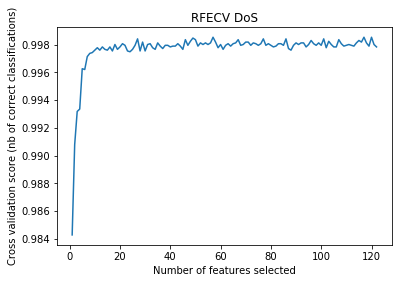

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv_DoS = RFECV(estimator=clf_DoS, step=1, cv=10, scoring='accuracy')
rfecv_DoS.fit(X_DoS_test, Y_DoS_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV DoS')
plt.plot(range(1, len(rfecv_DoS.grid_scores_) + 1), rfecv_DoS.grid_scores_)
plt.show()

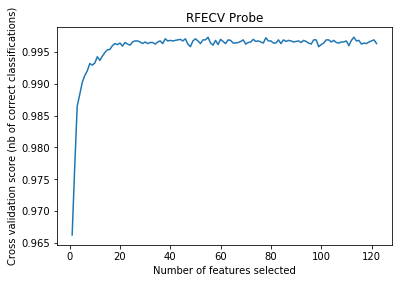

In [ ]:
rfecv_Probe = RFECV(estimator=clf_Probe, step=1, cv=10, scoring='accuracy')
rfecv_Probe.fit(X_Probe_test, Y_Probe_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV Probe')
plt.plot(range(1, len(rfecv_Probe.grid_scores_) + 1), rfecv_Probe.grid_scores_)
plt.show()

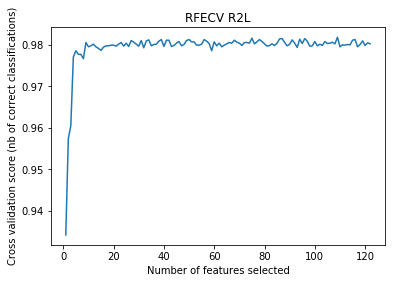

In [ ]:
rfecv_R2L = RFECV(estimator=clf_R2L, step=1, cv=10, scoring='accuracy')
rfecv_R2L.fit(X_R2L_test, Y_R2L_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV R2L')
plt.plot(range(1, len(rfecv_R2L.grid_scores_) + 1), rfecv_R2L.grid_scores_)
plt.show()

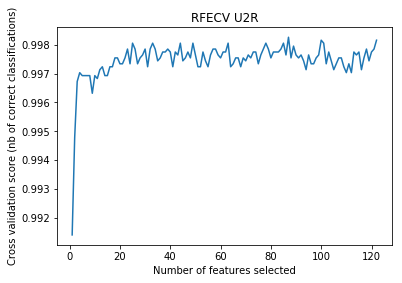

In [ ]:
rfecv_U2R = RFECV(estimator=clf_U2R, step=1, cv=10, scoring='accuracy')
rfecv_U2R.fit(X_U2R_test, Y_U2R_test)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.title('RFECV U2R')
plt.plot(range(1, len(rfecv_U2R.grid_scores_) + 1), rfecv_U2R.grid_scores_)
plt.show()

> Note: Using 13 Features for each category

## Confusion Matrices
## DoS

In [ ]:
# reduce test dataset to 13 features, use only features described in rfecolname_DoS etc.
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]
X_U2R_test2.shape

(9778, 13)

In [ ]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0   1
Actual attacks             
0                  9659  52
1                  7371  89

## Probe

In [ ]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0     2
Actual attacks               
0                  9087   624
2                  1160  1261

## R2L

In [ ]:
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0
Actual attacks         
0                  9711
3                  2885

## U2R

In [ ]:
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Predicted attacks     0  4
Actual attacks            
0                  9708  3
4                    63  4

## Cross Validation: Accuracy, Precision, Recall, F-measure

## DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99761 (+/- 0.00247)
Precision: 0.99825 (+/- 0.00241)
Recall: 0.99638 (+/- 0.00340)
F-measure: 0.99691 (+/- 0.00308)


## Probe

In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99349 (+/- 0.00407)
Precision: 0.99096 (+/- 0.00549)
Recall: 0.98802 (+/- 0.01040)
F-measure: 0.98809 (+/- 0.00870)


## R2L

In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97737 (+/- 0.00687)
Precision: 0.97094 (+/- 0.01240)
Recall: 0.96567 (+/- 0.01046)
F-measure: 0.96889 (+/- 0.01078)


## U2R

In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99785 (+/- 0.00193)
Precision: 0.94578 (+/- 0.11293)
Recall: 0.83649 (+/- 0.12050)
F-measure: 0.87971 (+/- 0.13580)


## Stratified CV => Stays the same

In [ ]:
from sklearn.model_selection import StratifiedKFold
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99755 (+/- 0.00312)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99341 (+/- 0.00383)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97761 (+/- 0.00865)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=StratifiedKFold(10), scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99714 (+/- 0.00327)


## CV 2, 5, 10, 30, 50 fold

## DoS

In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99720 (+/- 0.00070)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99720 (+/- 0.00190)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99715 (+/- 0.00252)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99726 (+/- 0.00380)


In [ ]:
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99720 (+/- 0.00480)


## Probe

In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99275 (+/- 0.00264)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99308 (+/- 0.00319)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99217 (+/- 0.00485)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99382 (+/- 0.00686)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99382 (+/- 0.00760)


## R2L

In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97602 (+/- 0.00128)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97809 (+/- 0.00268)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97801 (+/- 0.00582)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97761 (+/- 0.01276)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.97840 (+/- 0.01575)


## U2R

In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=2, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99703 (+/- 0.00020)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=5, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99683 (+/- 0.00041)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99703 (+/- 0.00359)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=30, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99704 (+/- 0.00513)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=50, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

Accuracy: 0.99734 (+/- 0.00586)


In [ ]:
import pandas as pd
import numpy as np
df_read =  pd.read_csv("./login_transformed.csv")
df=df_read

In [ ]:
#Encode the categorical features
from sklearn.preprocessing import LabelEncoder

encs = dict()
for column in df.columns:
    if df[column].dtype == "object":
        encs[column] = LabelEncoder()
        df[column] = encs[column].fit_transform(df[column])

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=200, max_samples=300)
df.head()

id  weekday  month  day  hour  user   pc  activity  threat
0  760033        5      1    2     6   707  589         1       0
1  203901        5      1    2     6   620  425         1       0
2  679565        5      1    2     6   620  410         1       0
3  264280        5      1    2     7   467  712         1       0
4  104103        5      1    2     7   675  668         1       0

In [ ]:
#Select the features you wan't to use by dropping all the other features:

df['hour_sin'] = np.sin(df.hour*(2.*np.pi/24))
df['hour_cos'] = np.cos(df.hour*(2.*np.pi/24))
df['month_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
df['weekday_sin'] = np.sin((df.weekday-1)*(2.*np.pi/12))
df['weekday_cos'] = np.cos((df.weekday-1)*(2.*np.pi/12))
df=df.drop('hour',1)
df=df.drop('month',1)
df=df.drop('weekday',1)

df=df.drop('id',1)
df=df.drop('day',1)
df=df.drop('user',1)
df=df.drop('pc',1)
df=df.drop('month_sin',1)
df=df.drop('month_cos',1)
df=df.drop('weekday_sin',1)
df=df.drop('weekday_cos',1)

df.head()

activity  threat  hour_sin      hour_cos
0         1       0  1.000000  6.123234e-17
1         1       0  1.000000  6.123234e-17
2         1       0  1.000000  6.123234e-17
3         1       0  0.965926 -2.588190e-01
4         1       0  0.965926 -2.588190e-01

In [ ]:
from scipy import stats

print("STARTING")

#If you want to produce lots of data, loop:
#for _ in range(500):

train_data=df.drop('threat',1)

try:
    train_data=df.drop('anomaly_score',1)
except:
    print("No anomaly_score column!")

### Try Isolation forest with different nummer of features ###
### The training parameters, i.e n_estimators, max_samples should also be evaluated ###

# Train the model
clf.fit(train_data)

# Calculate the anomaly score
anomaly_score = clf.decision_function(train_data)

# Add the anomaly score to the data frame
df['anomaly_score'] = anomaly_score

acctual_false = df.loc[df.threat==0]    #Data frame with true negatives
acctual_true = df.loc[df.threat==1]     #Data frame with true positives

features=[]
for element in train_data.columns:
    features.append(element)

(ks_stat, pval) = stats.ks_2samp(acctual_true.anomaly_score, acctual_false.anomaly_score)

#Print the features used together with the KS stat and p-value
print(str(features)+";"+str(ks_stat)+";"+str(pval)+"\n")

STARTING
No anomaly_score column!
['activity', 'hour_sin', 'hour_cos'];0.7325061508527233;2.2893017732084002e-94



Text(0.5,1,'Distribution of anomaly score for non threats')

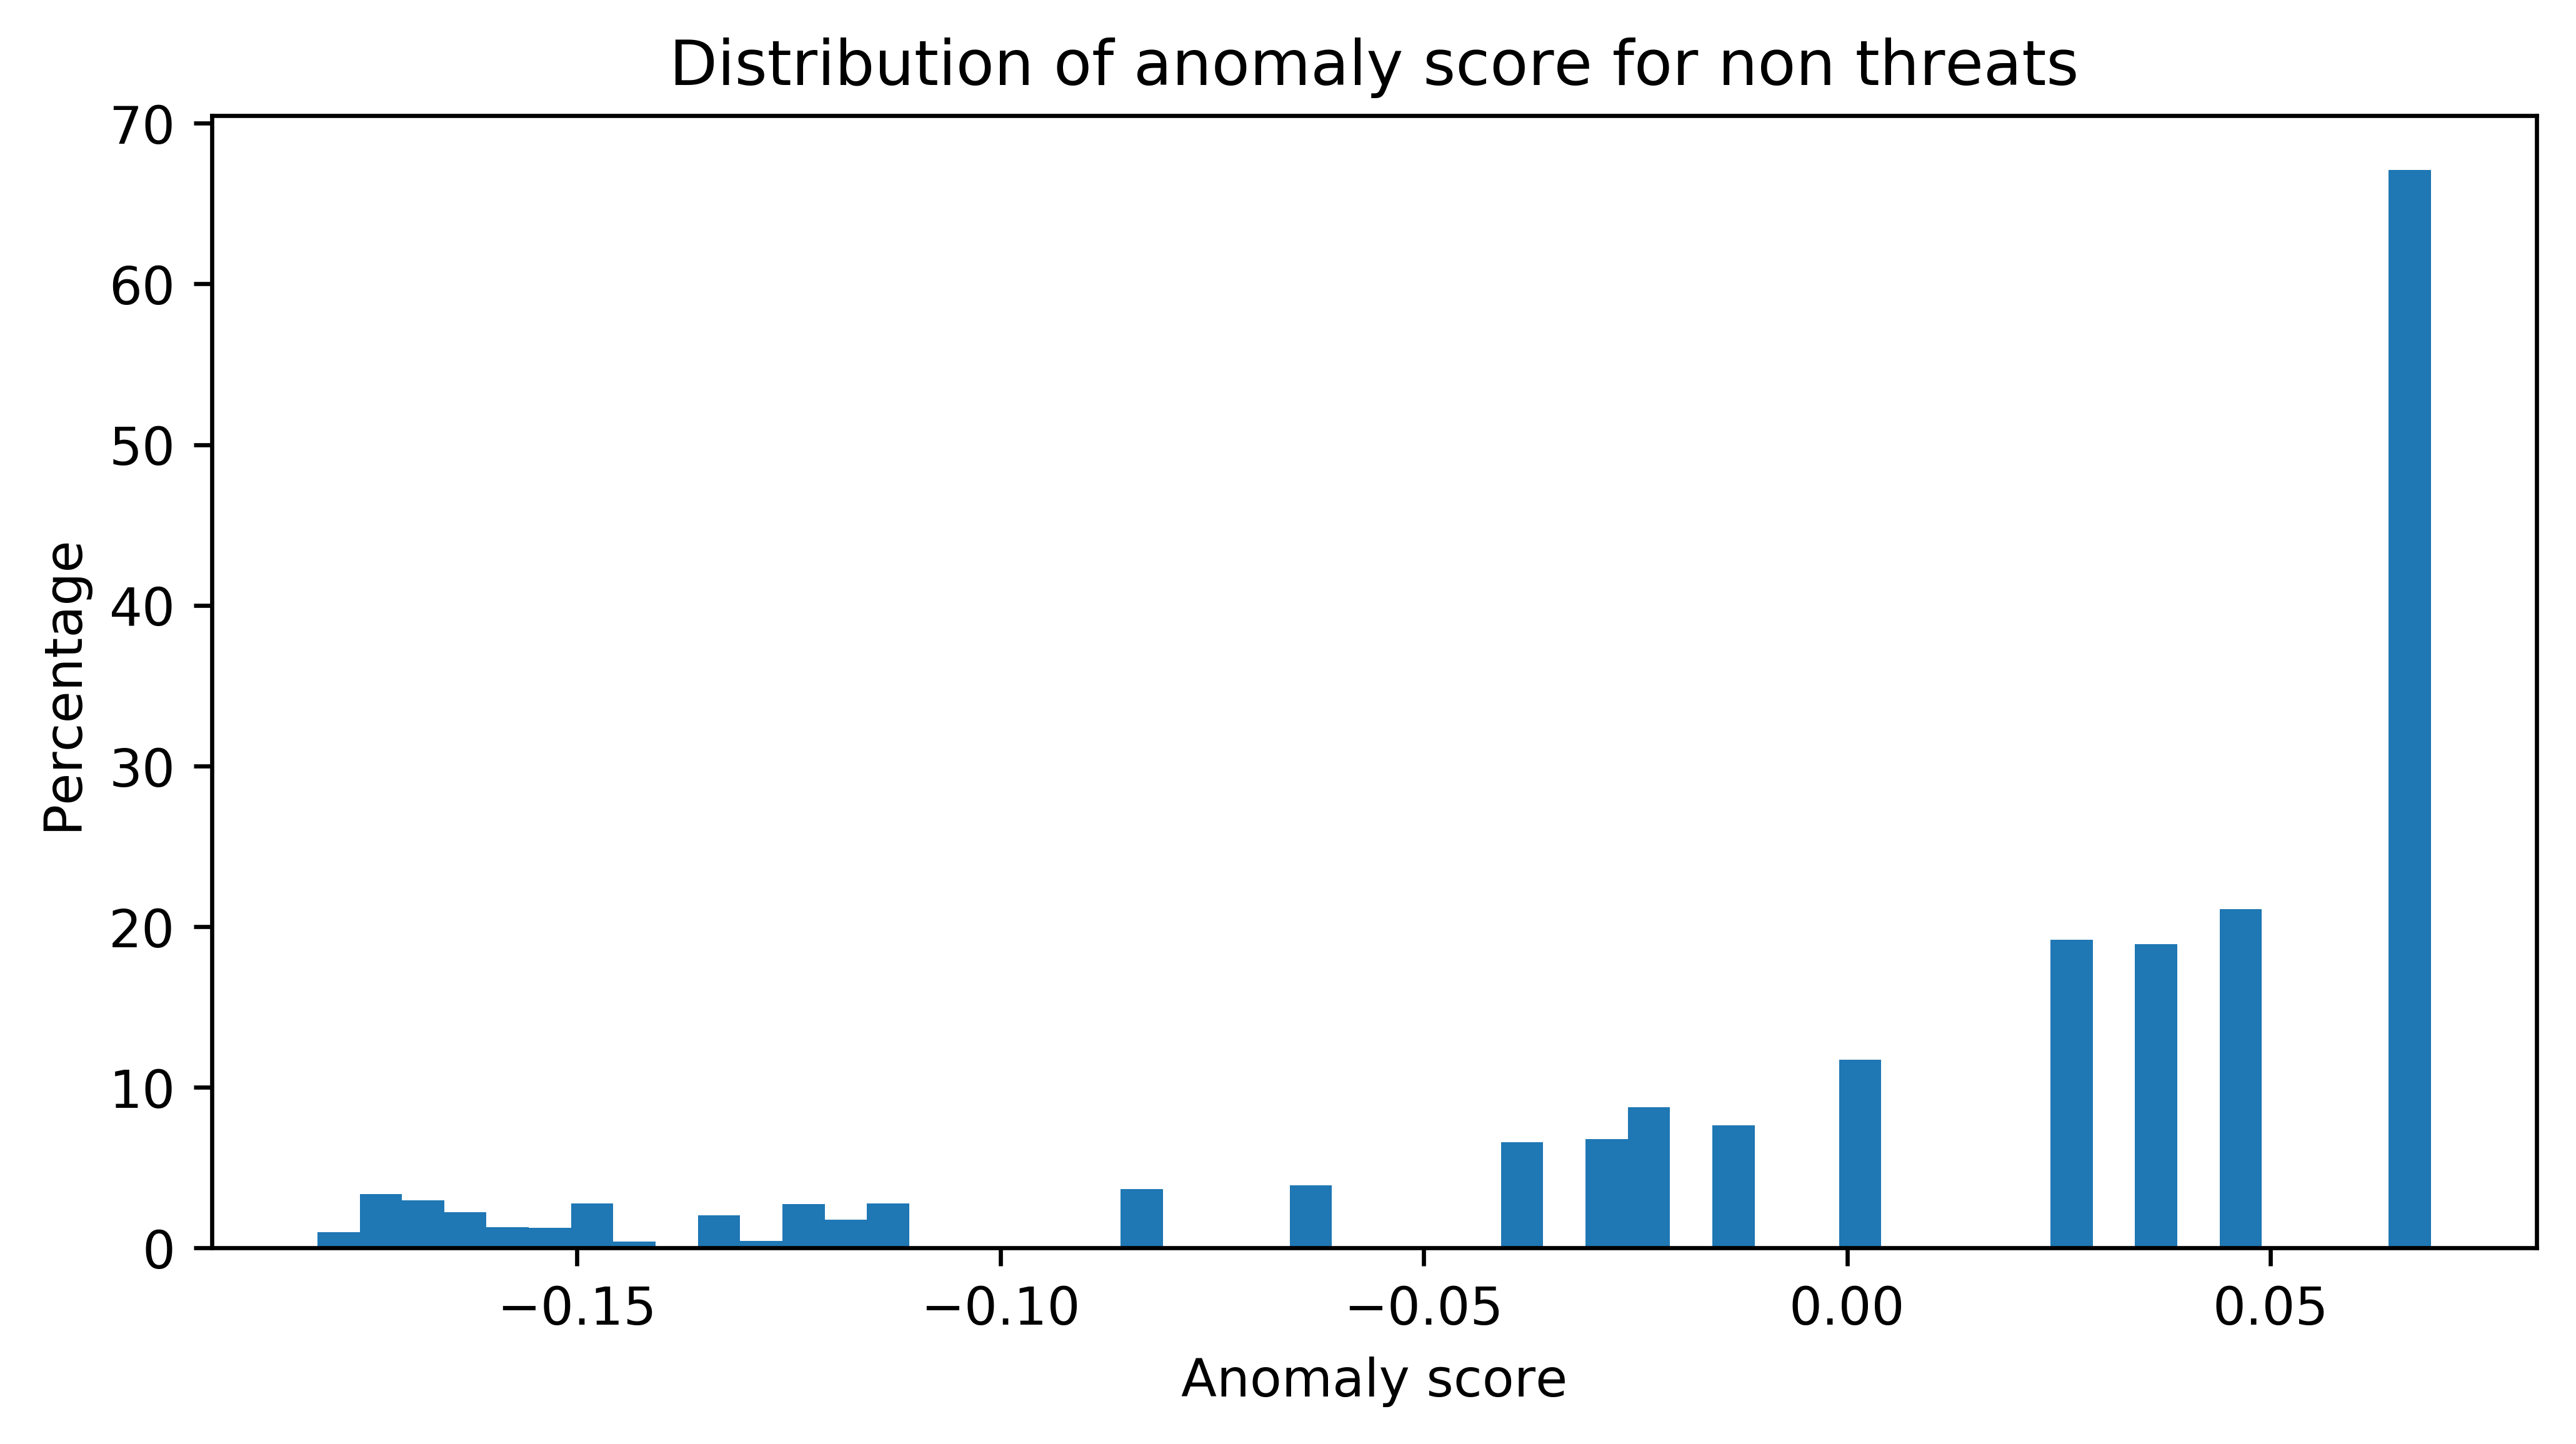

In [ ]:
#Plot the combined distribution of the scores 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 4), dpi=600, facecolor='w', edgecolor='k')

normal = plt.hist(acctual_false.anomaly_score, 50,density=True)

plt.xlabel('Anomaly score')
plt.ylabel('Percentage')
plt.title("Distribution of anomaly score for non threats")

Text(0.5,1,'Distribution of anomaly score for threats')

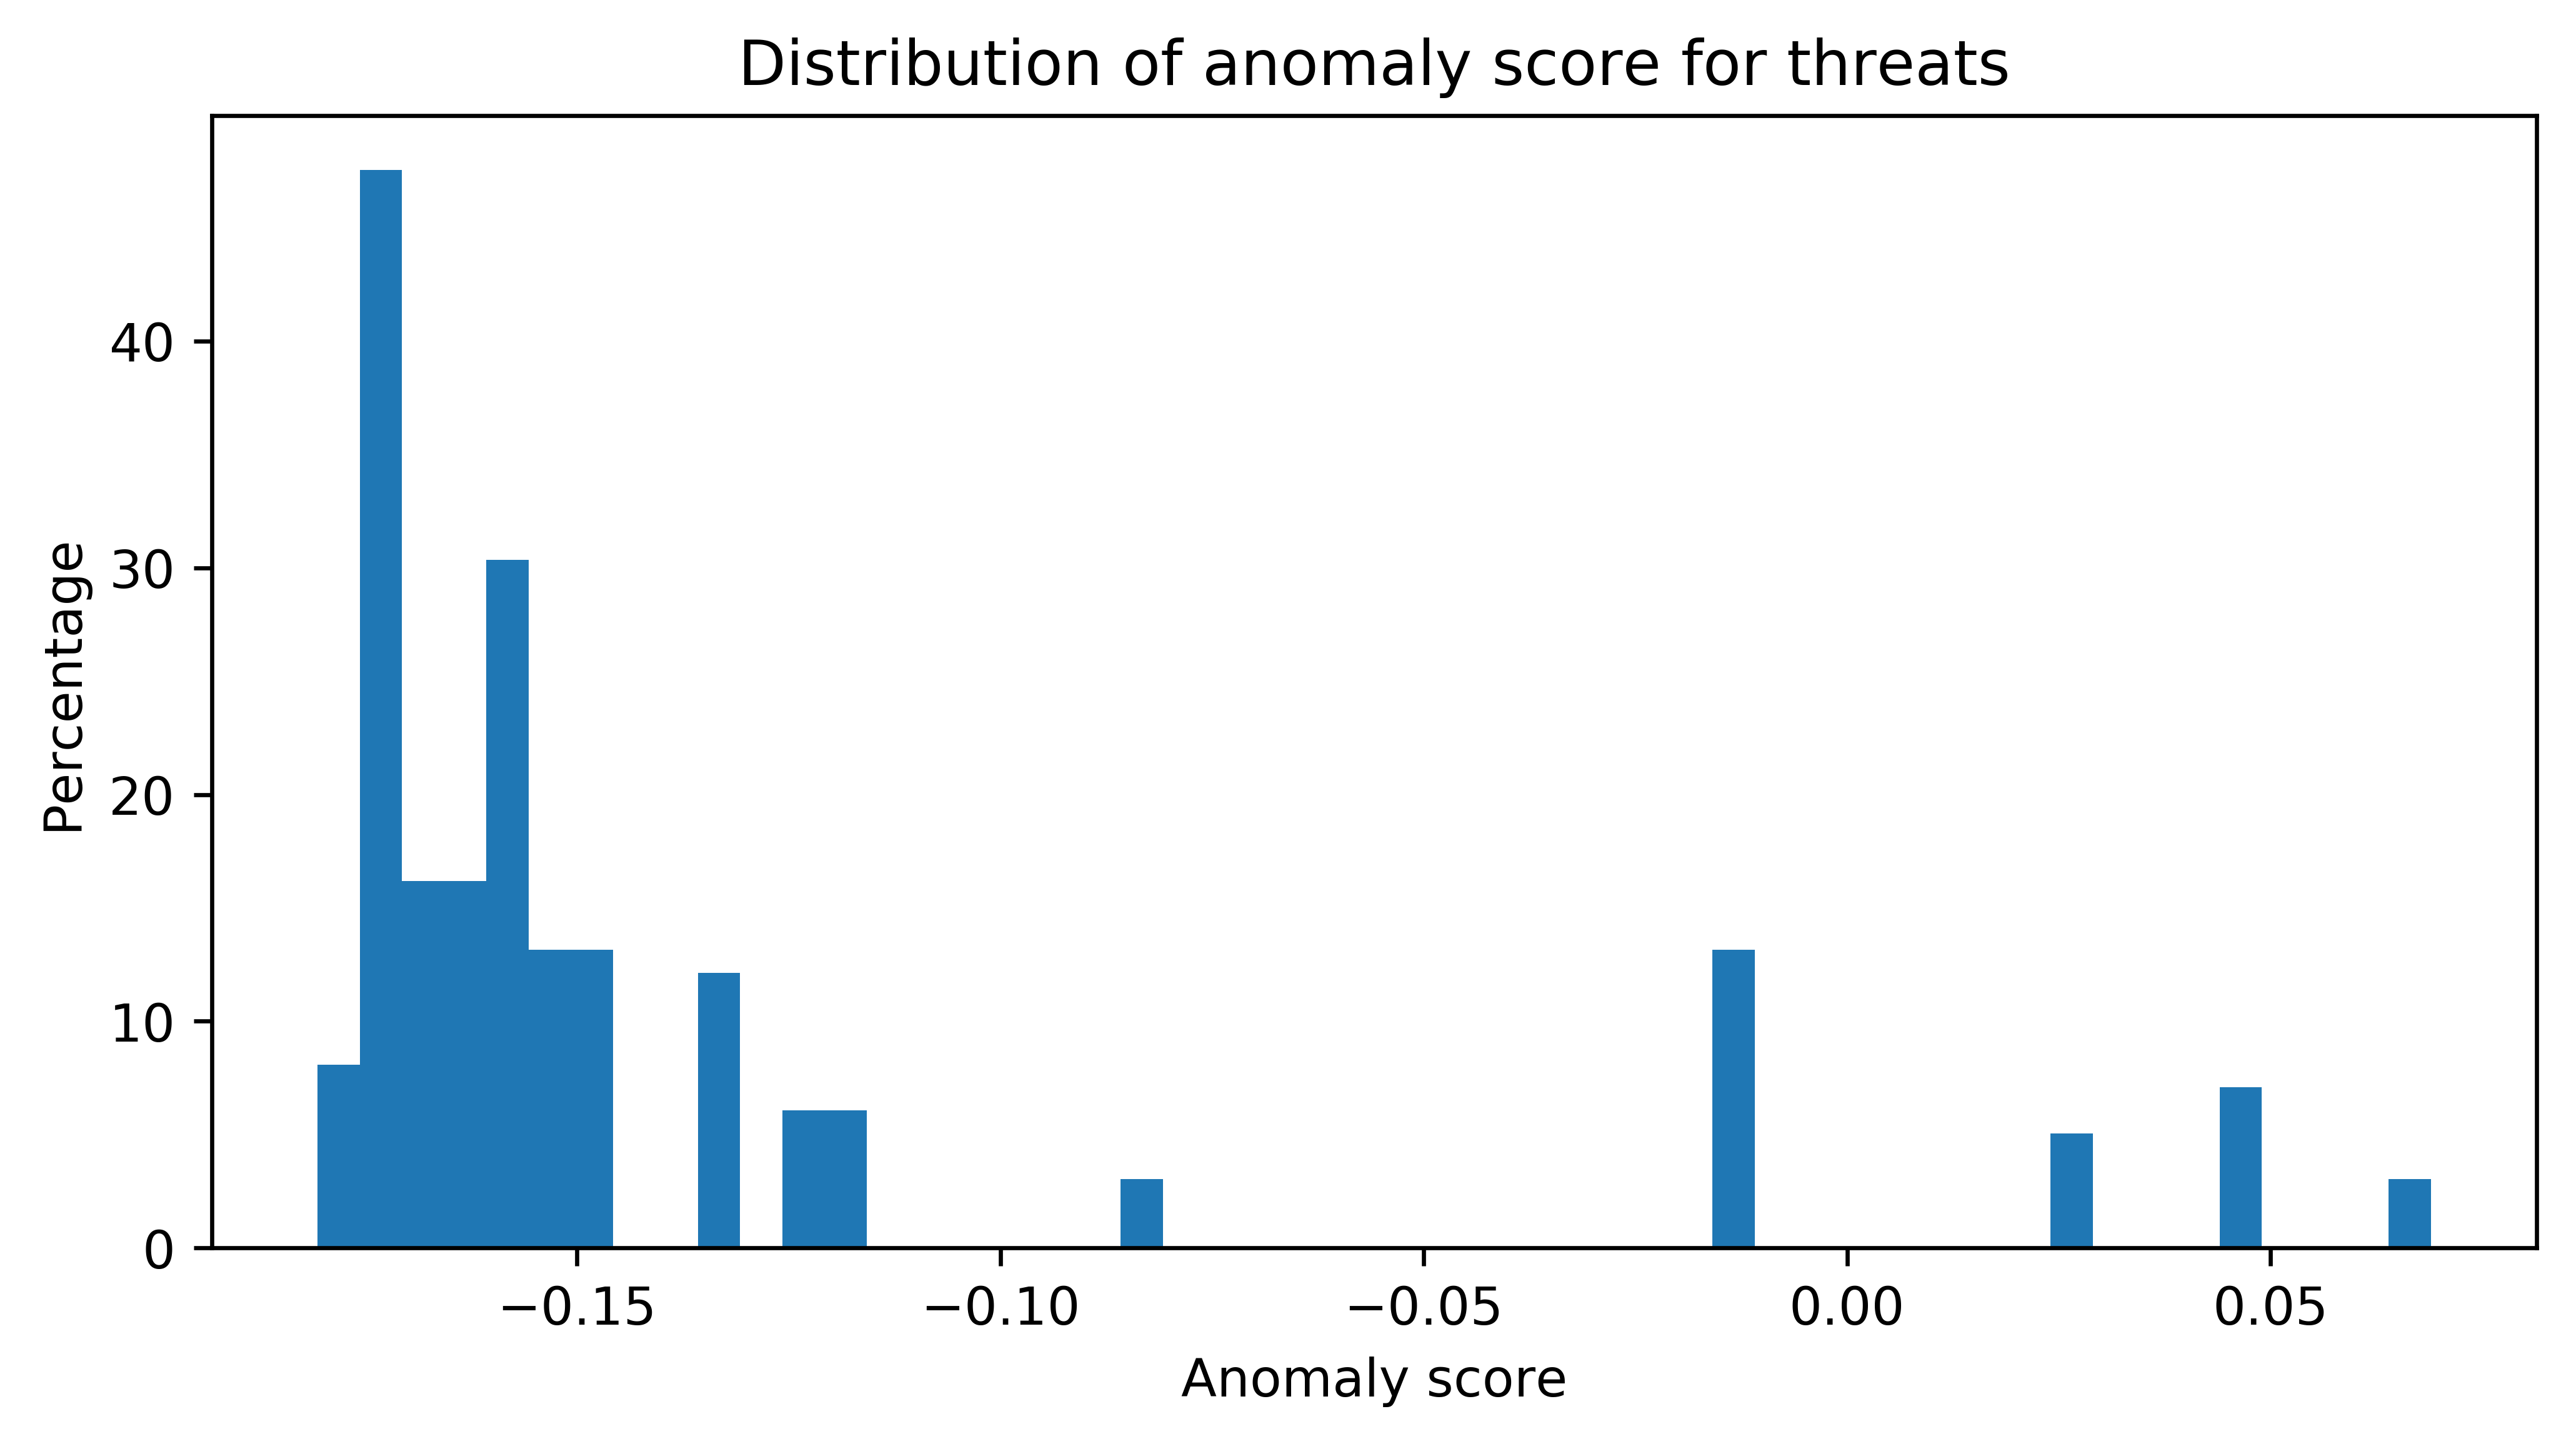

In [ ]:
#Plot the combined distribution of the scores 
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4), dpi=600, facecolor='w', edgecolor='k')

normal = plt.hist(acctual_true.anomaly_score, 50, density=True)

plt.xlabel('Anomaly score')
plt.ylabel('Percentage')
plt.title("Distribution of anomaly score for threats")


/home/jobu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


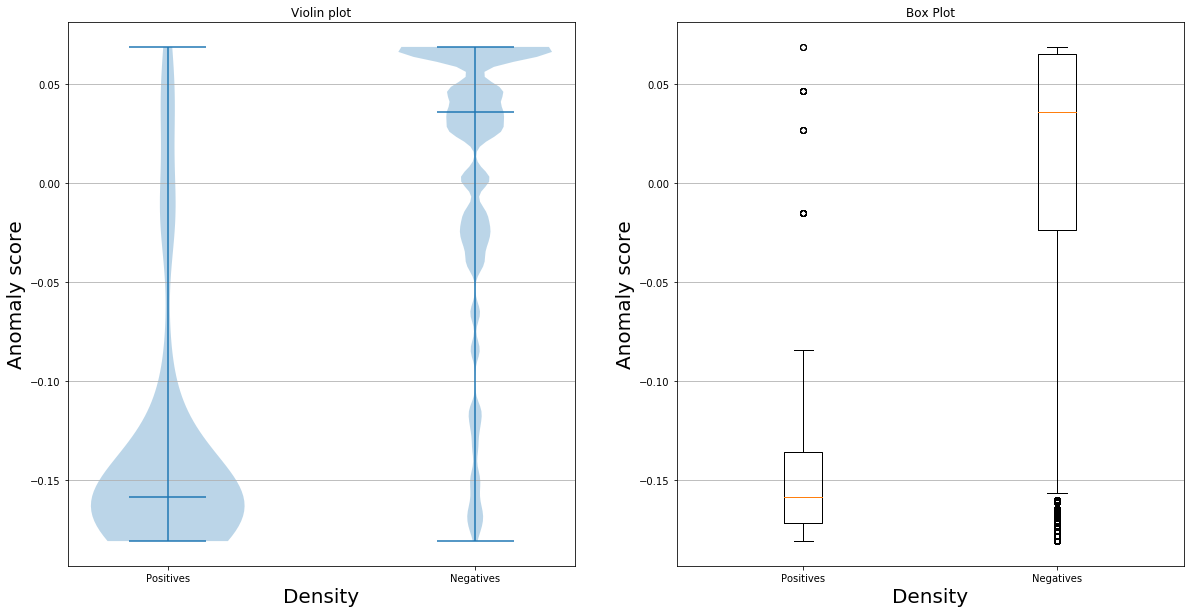

In [ ]:
#Let's create some fancy plots!

import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
all_data = [acctual_true['anomaly_score'],acctual_false['anomaly_score']]

axes[0].set_title('Violin plot')
# plot violin plot
axes[0].violinplot(all_data,
                   showmeans=False,
                   showmedians=True)

# plot box plot
axes[1].boxplot(all_data)
axes[1].set_title('Box Plot')

for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(all_data))])
    ax.set_xlabel('Density', fontsize=20)
    ax.set_ylabel('Anomaly score', fontsize=20)

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
         xticklabels=['Positives', 'Negatives'])

plt.show()


In [ ]:
# Now let's create the confusion matrix!
# This code will try to find the best limit value to apply on the anomaly score. 
# All data points with a score lower than the limit will be considered as threats (positives).
# We use Matthews Correlation Coefficient to evaluate the results and pick the "best" limit.

from sklearn.metrics import matthews_corrcoef

def calculateMatthews(limit):
    #Predict all anomaly scores < limit as threats:
    df['pred_threat'] = np.where(df.anomaly_score < limit, 1, 0)
    
    #Evaluate..
    
    total_negatives = len(acctual_false.index)
    total_positives = len(acctual_true.index)

    true_positives = acctual_true[(acctual_true['anomaly_score'] < limit)]
    false_positives = acctual_false[(acctual_false['anomaly_score'] < limit)]

    false_negatives = acctual_true[(acctual_true['anomaly_score'] >= limit)]
    true_negatives = acctual_false[(acctual_false['anomaly_score'] >= limit)]

    tp = len(true_positives)
    fp = len(false_positives)
    fn = len(false_negatives)
    tn = len(true_negatives)

    tp_rate = tp/total_positives
    fp_rate = fp/total_negatives
    fn_rate = fn/total_positives
    tn_rate = tn/total_negatives
    
    if(tp + fp == 0):
        precision = 0
    else:
        precision = tp/(tp + fp)
        
    if(tp + fn == 0):
        recall = 0
    else:
        recall = tp/(tp + fn)        

    predicted_true = df.loc[df.anomaly_score < limit]

    mcc = matthews_corrcoef(df['threat'], df['pred_threat'])
    
    #print("tp_rate: " + str(tp_rate))
    #print("fp_rate: " + str(fp_rate))
    #print("fn_rate: " + str(fn_rate))
    #print("tn_rate: " + str(tn_rate))      
    #print("mcc "+str(mcc))
    return(mcc, precision, recall, tp_rate, fp_rate, fn_rate, tn_rate)


#Place the upper and lower limit (start/stop) just below and above the min and max anomaly score value.
lower_limit = -0.25

lower_limit = df.anomaly_score.min()-0.05
upper_limit = df.anomaly_score.max()+0.05

max_mat=0.0
max_limit=-100.0
best_precision = 0
best_recall = 0
best_tp = 0
best_fp = 0
best_tn = 0
best_tp = 0

limit=lower_limit
mat_array=[]
limit_array=[]
tp_array = []
fp_array = []
fn_array = []
tn_array = []

#Try a few different step sizes:
step_size = 0.011

#Try a lot of different limits to find the one that scores the highest MCC
while(limit < upper_limit):
    limit=limit+step_size
    (mat, precision, recall, tp_rate, fp_rate, fn_rate, tn_rate)=calculateMatthews(limit)
    
    print("MCC: "+str(mat)+"  Limit: "+str(limit))
    mat_array.append(mat)
    limit_array.append(limit)
    tp_array.append(tp_rate)
    fp_array.append(fp_rate)
    fn_array.append(fn_rate)
    tn_array.append(tn_rate)
    if abs(mat) > max_mat:
        max_mat = mat
        max_limit = limit
        best_precision = precision
        best_tp = tp_rate
        best_fp = fp_rate
        best_tn = tn_rate
        best_fn = fn_rate
        best_recall = recall
        
print("Best limit    : " + str(max_limit))
print("Best MCC      : " + str(max_mat))
print("Best Precision: " + str(best_precision))
print("Best Recall   : " + str(best_recall))
print("Best TN       : " + str(best_tn))
print("Best TP       : " + str(best_tp))
print("Best FN       : " + str(best_fn))
print("Best FP       : " + str(best_fp))

/home/jobu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.0  Limit: -0.21965016842951596
MCC: 0.0  Limit: -0.20865016842951595
MCC: 0.0  Limit: -0.19765016842951594
MCC: 0.0  Limit: -0.18665016842951593
MCC: 0.007675885963744385  Limit: -0.17565016842951592
MCC: 0.02869967618145181  Limit: -0.1646501684295159
MCC: 0.03712006211454893  Limit: -0.1536501684295159
MCC: 0.037064980110526766  Limit: -0.1426501684295159
MCC: 0.03824474391155064  Limit: -0.13165016842951588
MCC: 0.03571115887684748  Limit: -0.12065016842951588
MCC: 0.03307328196989446  Limit: -0.10965016842951589
MCC: 0.03307328196989446  Limit: -0.09865016842951589
MCC: 0.03307328196989446  Limit: -0.0876501684295159
MCC: 0.031091445842227755  Limit: -0.0766501684295159
MCC: 0.031091445842227755  Limit: -0.0656501684295159
MCC: 0.028697524052725038  Limit: -0.05465016842951591
MCC: 0.028697524052725038  Limit: -0.04365016842951591
MCC: 0.0254377221047062  Limit: -0.032650168429515916
MCC: 0.01999509742271356  Limit: -0.021650168429515917
MCC: 0.020146895016962894  Limit: -0.

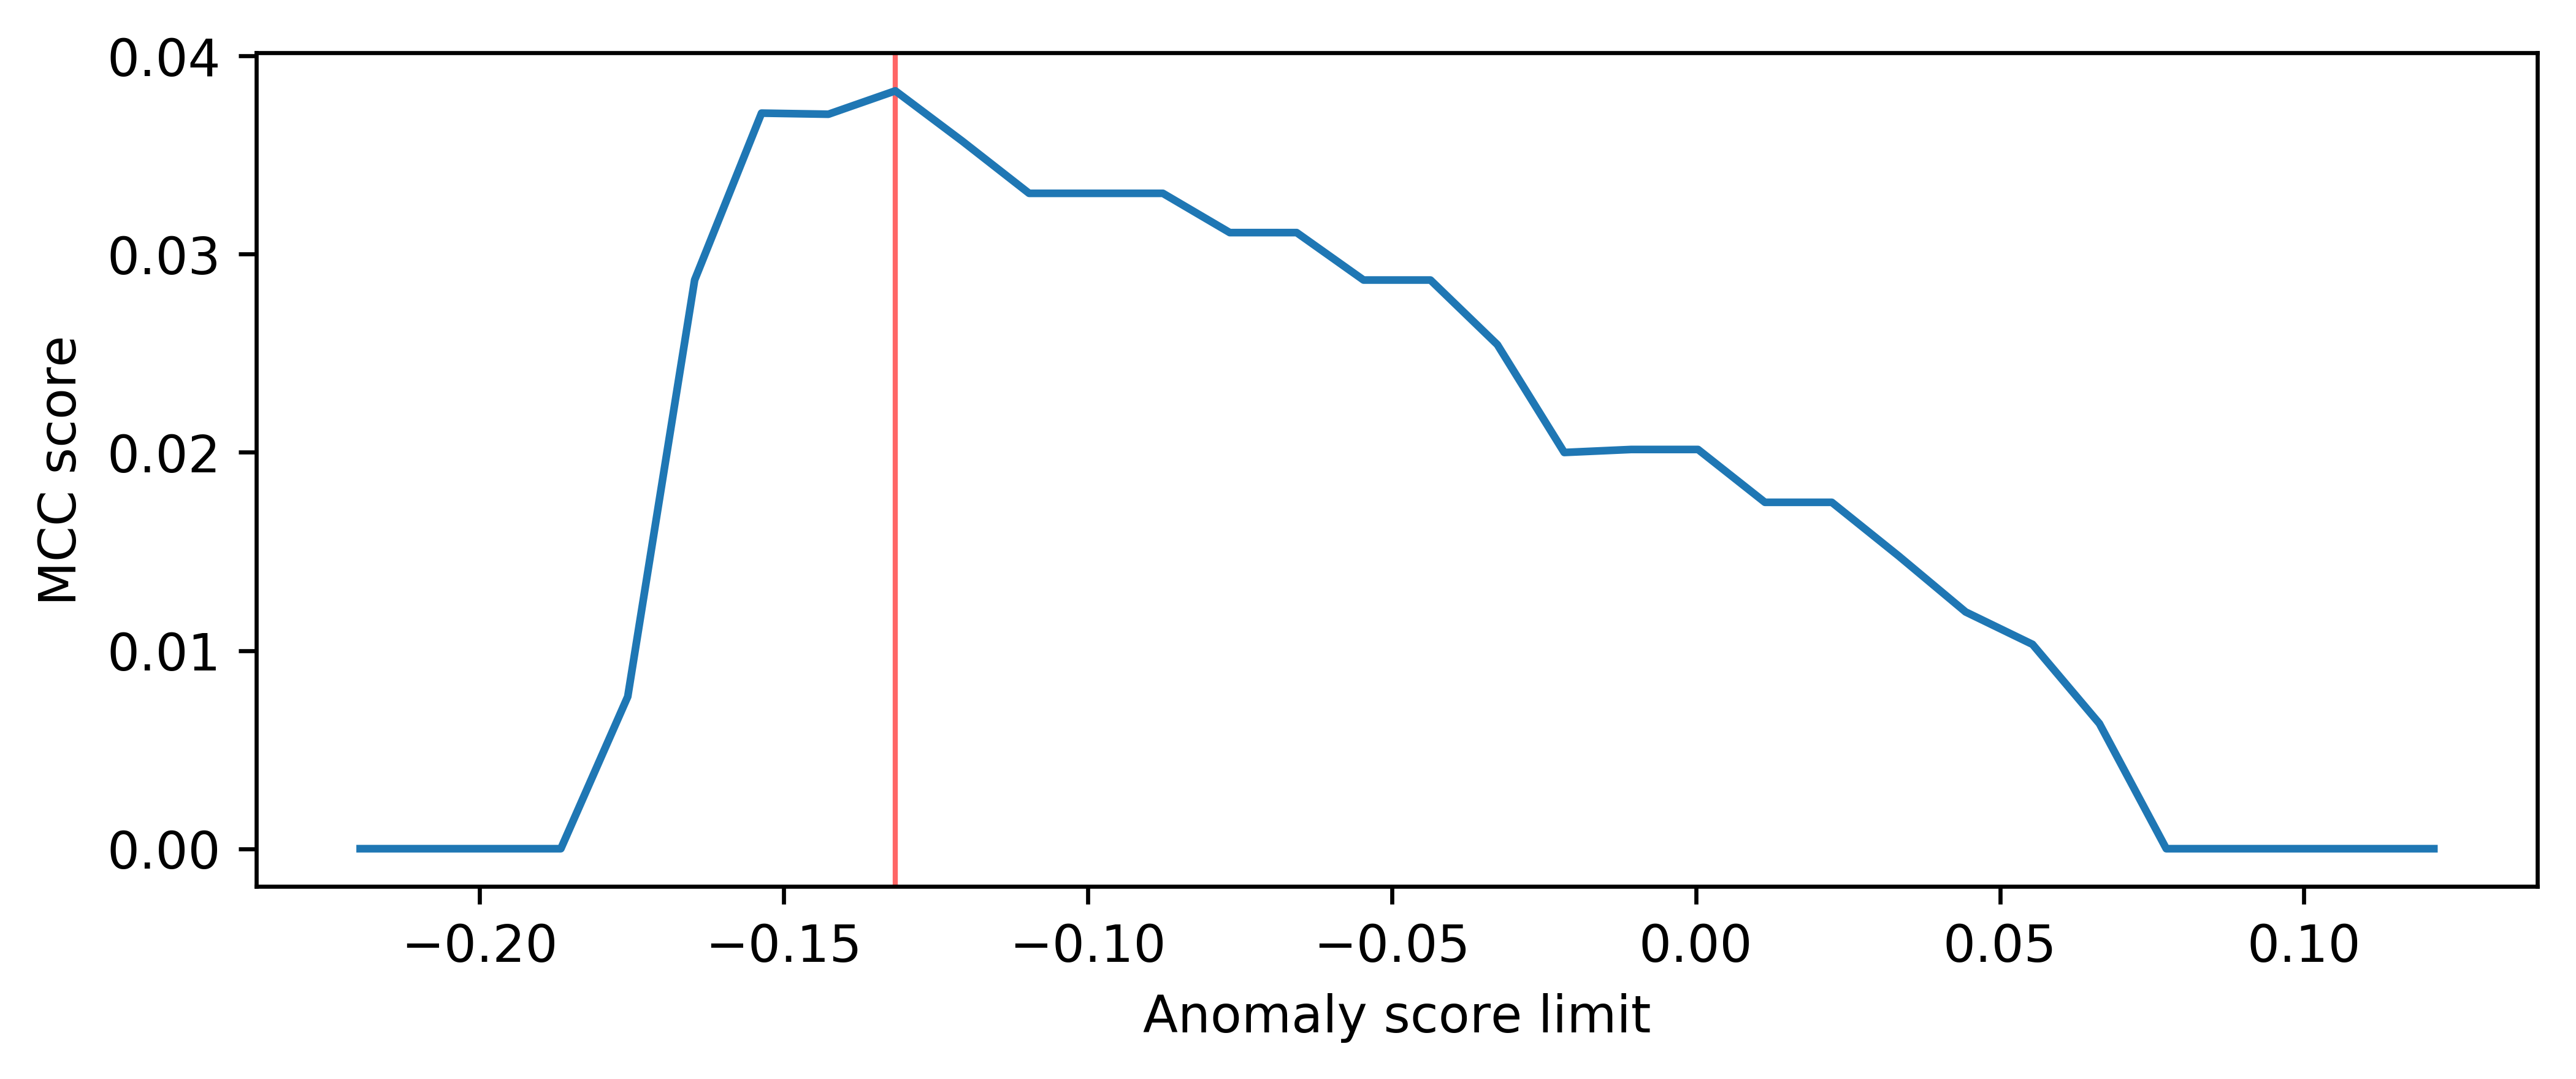

In [ ]:
fig = plt.figure(figsize=(8,3),dpi=600,facecolor='w', edgecolor='k')
plt.xlabel('Anomaly score limit')
plt.ylabel('MCC score')
plt.title('')
plt.plot(limit_array, mat_array)
#Highlight the best limit manually..
plt.axvspan(max_limit, max_limit, color='red', alpha=0.6)
plt.show()

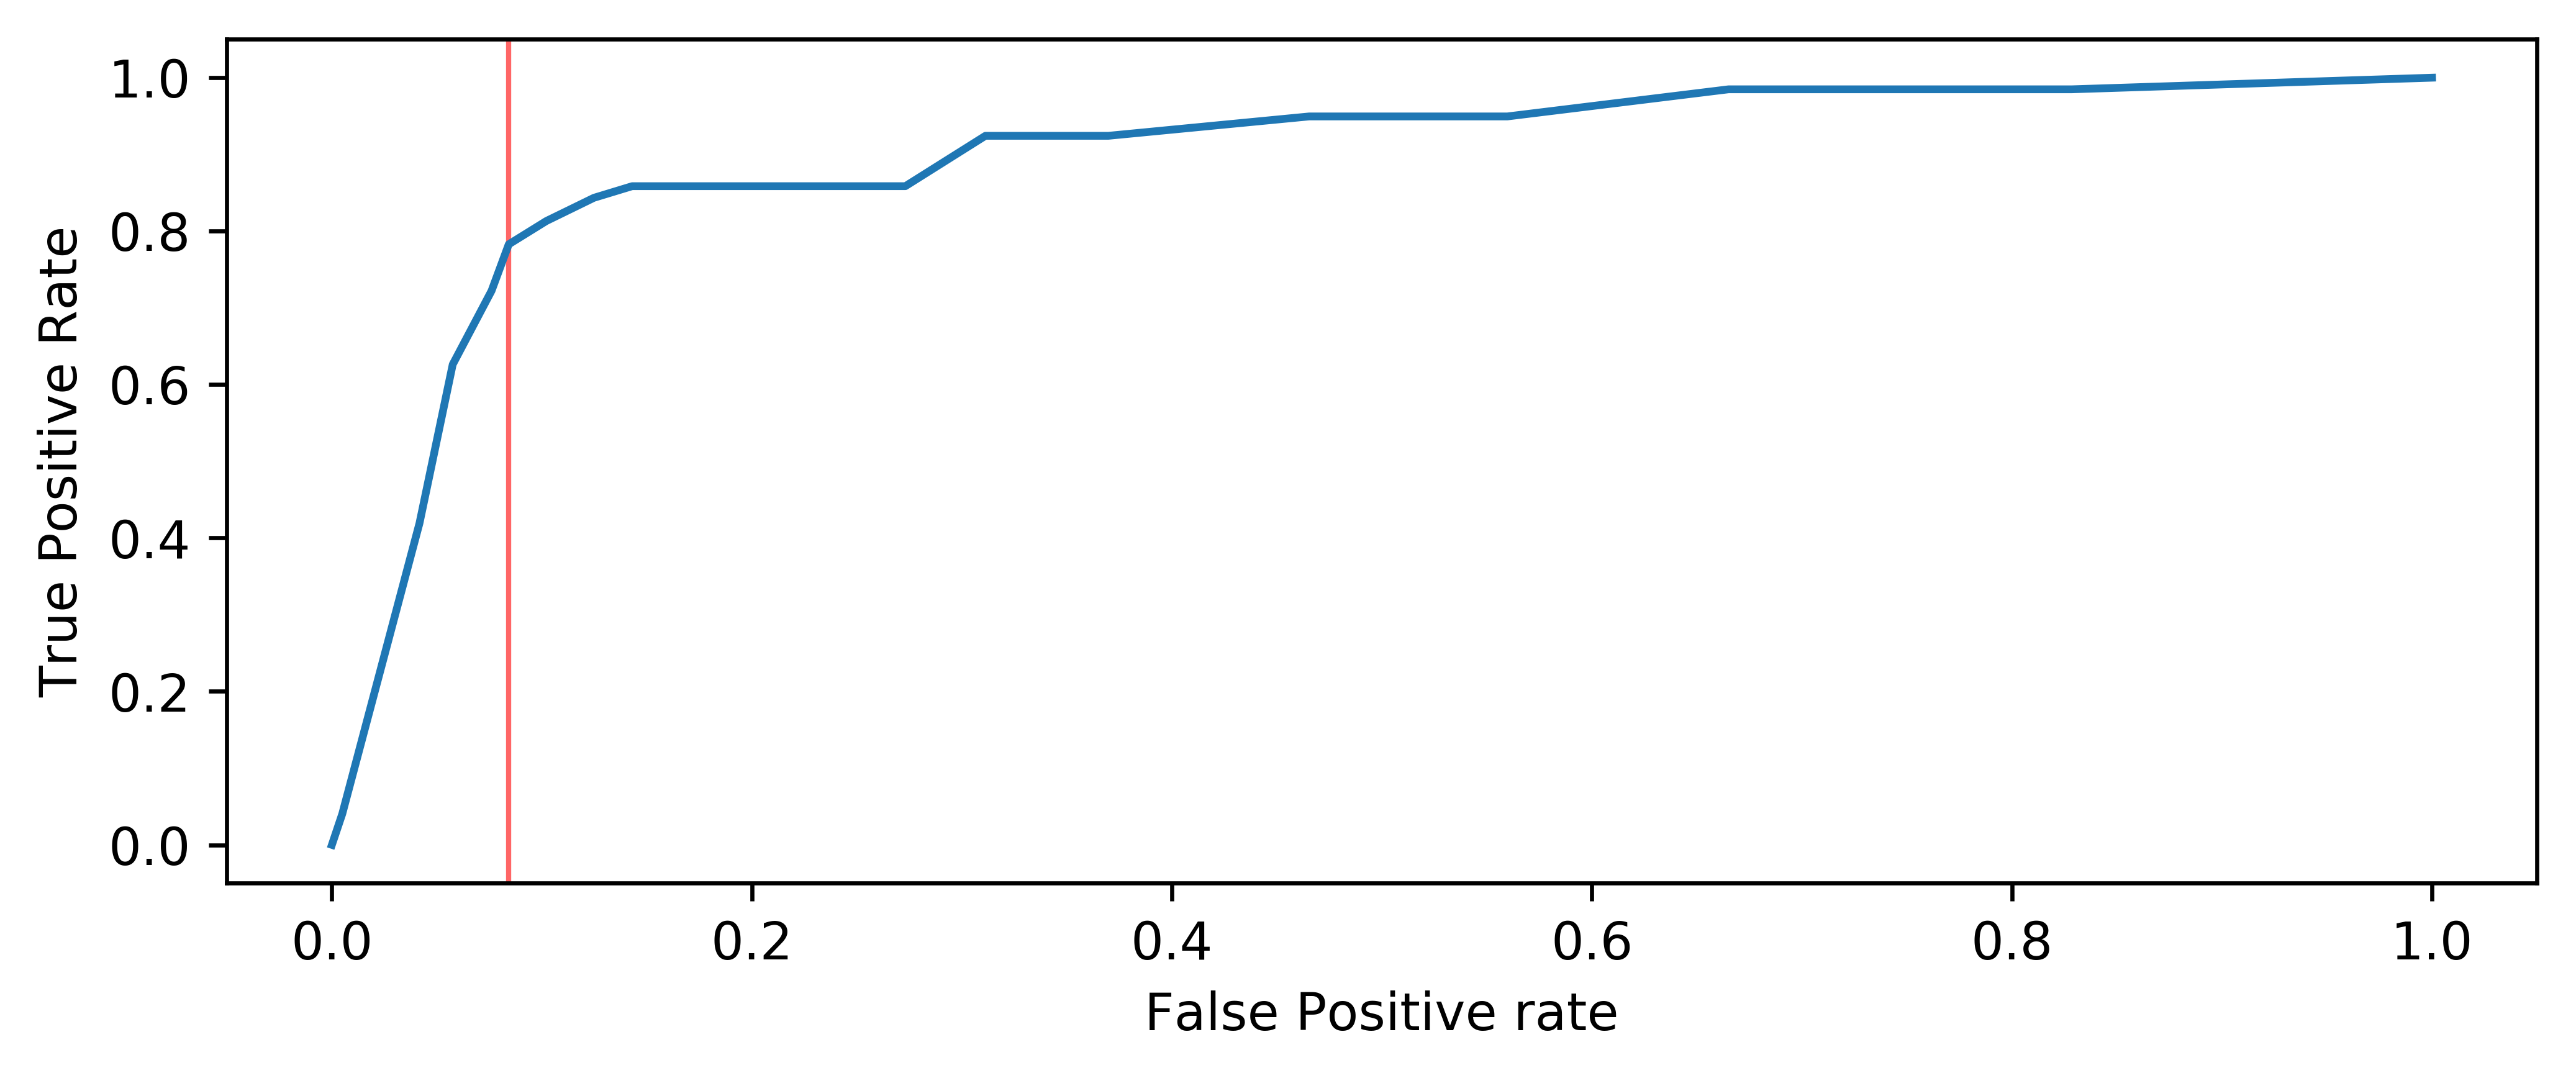

In [ ]:
#Plot true positive rate vs false positive rate

fig = plt.figure(figsize=(8,3),dpi=600,facecolor='w', edgecolor='k')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.axvspan(best_fp, best_fp, color='red', alpha=0.6)
plt.plot(fp_array, tp_array)
plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D, Activation
from keras.layers import LSTM, Lambda, Bidirectional, concatenate, BatchNormalization
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.utils import np_utils
import keras.backend as K
import numpy as np
import tensorflow as tf
import keras.callbacks
import sys
import os
import cPickle as pickle
from timeit import default_timer as timer
import glob
import time

LSTM_UNITS = 92
MINI_BATCH = 10
TRAIN_STEPS_PER_EPOCH = 12000
VALIDATION_STEPS_PER_EPOCH = 800
DATA_DIR = '/root/data/PreprocessedISCX2012_5class_pkl/'
CHECKPOINTS_DIR = './iscx2012_cnn_rnn_5class_new_checkpoints/'

dict_5class = {0:'Normal', 1:'BFSSH', 2:'Infilt', 3:'HttpDoS', 4:'DDoS'}

def update_confusion_matrix(confusion_matrix, actual_lb, predict_lb):
    for idx, value in enumerate(actual_lb):
        p_value = predict_lb[idx]
        confusion_matrix[value, p_value] += 1
    return confusion_matrix

# function: find an element in a list
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def truncate(f, n):
    trunc_f = np.math.floor(f * 10 ** n) / 10 ** n
    return '{:.2f}'.format(trunc_f) # only for 0.0 => 0.00

def binarize(x, sz=256):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))

def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 256

def byte_block(in_layer, nb_filter=(64, 100), filter_length=(3, 3), subsample=(2, 1), pool_length=(2, 2)):
    block = in_layer
    for i in range(len(nb_filter)):
        block = Conv1D(filters=nb_filter[i],
                       kernel_size=filter_length[i],
                       padding='valid',
                       activation='tanh',
                       strides=subsample[i])(block)
        # block = BatchNormalization()(block)
        # block = Dropout(0.1)(block)
        if pool_length[i]:
            block = MaxPooling1D(pool_size=pool_length[i])(block)

    # block = Lambda(max_1d, output_shape=(nb_filter[-1],))(block)
    block = GlobalMaxPool1D()(block)
    block = Dense(128, activation='relu')(block)
    return block

def mini_batch_generator(sessions, labels, indices, batch_size):
    Xbatch = np.ones((batch_size, PACKET_NUM_PER_SESSION, PACKET_LEN), dtype=np.int64) * -1
    Ybatch = np.ones((batch_size,5), dtype=np.int64) * -1
    batch_idx = 0
    while True:
        for idx in indices:
            for i, packet in enumerate(sessions[idx]):
                if i < PACKET_NUM_PER_SESSION:
                    for j, byte in enumerate(packet[:PACKET_LEN]):
                        Xbatch[batch_idx, i, (PACKET_LEN - 1 - j)] = byte            
            Ybatch[batch_idx] = np_utils.to_categorical(labels[idx], num_classes=5)[0]
            batch_idx += 1
            if batch_idx == batch_size:
                batch_idx = 0
                yield (Xbatch, Ybatch)

# read argv
print ("Script name: %s" % str(sys.argv[0]))
checkpoint = None
if len(sys.argv) == 2:
    if os.path.exists(str(sys.argv[1])):
        print ("Checkpoint : %s" % str(sys.argv[1]))
        checkpoint = str(sys.argv[1])        
# if len(sys.argv) == 5:
#     if os.path.exists(str(sys.argv[4])):
#         print ("Checkpoint : %s" % str(sys.argv[4]))
#         checkpoint = str(sys.argv[4])

# read sessions and labels from pickle files
sessions = []
labels = []
t1 = timer()
num_pkls = len(glob.glob(DATA_DIR + 'ISCX2012_labels_*.pkl'))
for i in range(num_pkls):
    session_pkl = DATA_DIR + 'ISCX2012_pcaps_' + str(i) + '.pkl'
    session_lists  = pickle.load(open(session_pkl, 'rb'))
    sessions.extend(session_lists)
    label_pkl = DATA_DIR + 'ISCX2012_labels_' + str(i) + '.pkl'
    label_lists = pickle.load(open(label_pkl, 'rb'))    
    labels.extend(label_lists)    
    print i
t2 = timer()
print t2 - t1
print('Sample doc{}'.format(sessions[1200]))
labels = np.array(labels)

# arg_list = [[50,6],[100,6],[200,6],[300,6],[400,6],[500,6],[600,6],[700,6],[800,6],[900,6],[1000,6],
#             [100,8],[100,10],[100,12],[100,14],[100,16],[100,18],[100,20],[100,22],[100,24],[100,26],[100,28],[100,30]]
# arg_list = [[100,12],[100,14],[100,16],[100,18],[100,20],[100,22],[100,24],[100,26],[100,28],[100,30]]
arg_list = [[600,14],[700,14],[800,14],[900,14],[1000,14]]
# arg_list = [[100,6]]
for arg in arg_list:
    PACKET_LEN = arg[0]
    PACKET_NUM_PER_SESSION = arg[1]
    TRAIN_EPOCHS = 8

    # create train/validate data generator 
    normal_indices = np.where(labels == 0)[0]
    attack_indices = [np.where(labels == i)[0] for i in range(1,5)]
    print len(normal_indices)
    print len(attack_indices)
    test_normal_indices = np.random.choice(normal_indices, int(len(normal_indices)*0.4))
    test_attack_indices = np.concatenate([np.random.choice(attack_indices[i], int(len(attack_indices[i])*0.4)) for i in range(4)])
    test_indices = np.concatenate([test_normal_indices, test_attack_indices]).astype(int)
    train_indices = np.array(list(set(np.arange(len(labels))) - set(test_indices)))
    train_data_generator  = mini_batch_generator(sessions, labels, train_indices, MINI_BATCH)
    val_data_generator    = mini_batch_generator(sessions, labels, test_indices, MINI_BATCH)
    test_data_generator   = mini_batch_generator(sessions, labels, test_indices, MINI_BATCH)

    # create model
    session = Input(shape=(PACKET_NUM_PER_SESSION, PACKET_LEN), dtype='int64')
    input_packet = Input(shape=(PACKET_LEN,), dtype='int64')
    embedded = Lambda(binarize, output_shape=binarize_outshape)(input_packet)
    block2 = byte_block(embedded, (128, 256), filter_length=(5, 5), subsample=(1, 1), pool_length=(2, 2))
    block3 = byte_block(embedded, (192, 320), filter_length=(7, 5), subsample=(1, 1), pool_length=(2, 2))
    packet_encode = concatenate([block2, block3], axis=-1)
    # packet_encode = Dropout(0.2)(packet_encode)
    encoder = Model(inputs=input_packet, outputs=packet_encode)
    encoder.summary()
    encoded = TimeDistributed(encoder)(session)
    lstm_layer = LSTM(LSTM_UNITS, return_sequences=True, dropout=0.1, recurrent_dropout=0.1, implementation=0)(encoded)
    lstm_layer2 = LSTM(LSTM_UNITS, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, implementation=0)(lstm_layer)
    dense_layer = Dense(5, name='dense_layer')(lstm_layer2)
    output = Activation('softmax')(dense_layer)
    model = Model(outputs=output, inputs=session)
    model.summary()

    # if input checkpoint, test with saved model and save predicted results
    if checkpoint:
        model.load_weights(checkpoint)
        sub_model = Model(inputs=model.input,
                        outputs=model.get_layer('dense_layer').output)
        test_steps = np.math.ceil(float(len(test_indices)) / MINI_BATCH)
        embd = sub_model.predict_generator(test_data_generator, steps=test_steps)
        print type(embd)
        print embd.shape
        print len(embd)
        print embd[0]
        np.save('./embeddings_iscx2012.npy', embd)
        np.save('./labels_iscx2012.npy', labels[test_indices])
        break

    # train and validate model
    script_name = os.path.basename(sys.argv[0]).split('.')[0]
    weight_file = CHECKPOINTS_DIR + script_name + '_' + str(PACKET_LEN) + '_' + str(PACKET_NUM_PER_SESSION) + '_{epoch:02d}_{val_loss:.2f}.hdf5'
    check_cb = keras.callbacks.ModelCheckpoint(weight_file, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='min')
    earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    train_time = 0
    start_train = timer()
    model.fit_generator(
        generator=train_data_generator, 
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        epochs=TRAIN_EPOCHS,
        callbacks=[check_cb, earlystop_cb],
        validation_data=val_data_generator,
        validation_steps=VALIDATION_STEPS_PER_EPOCH)
    end_train = timer()
    train_time = end_train - start_train

    # test model
    start_test = timer()
    test_steps = np.math.ceil(float(len(test_indices)) / MINI_BATCH)
    predictions = model.predict_generator(test_data_generator, steps=test_steps)
    end_test = timer()
    test_time = end_test - start_test

    # stat and save
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = labels[test_indices]
    if len(predicted_labels) > len(true_labels):
        num_pad = len(predicted_labels) - len(true_labels)
        true_labels = np.concatenate([true_labels, true_labels[0:num_pad]])
    print len(predicted_labels)
    print len(true_labels)
    len_test = len(true_labels)
    cf_ma = np.zeros((5,5), dtype=int)
    update_confusion_matrix(cf_ma, true_labels, predicted_labels)
    metrics_list = []
    for i in range(5):
        if i == 0:
            metrics_list.append([dict_5class[i], str(i), str(cf_ma[i,0]), str(cf_ma[i,1]), str(cf_ma[i,2]), str(cf_ma[i,3]), str(cf_ma[i,4]), '--', '--', '--'])
        else:
            acc = truncate((float(len_test-cf_ma[:,i].sum()-cf_ma[i,:].sum()+cf_ma[i,i]*2)/len_test)*100, 2)
            tpr = truncate((float(cf_ma[i,i])/cf_ma[i].sum())*100, 2)
            fpr = truncate((float(cf_ma[0,i])/cf_ma[0].sum())*100, 2)
            metrics_list.append([dict_5class[i], str(i), str(cf_ma[i,0]), str(cf_ma[i,1]), str(cf_ma[i,2]), str(cf_ma[i,3]), str(cf_ma[i,4]), str(acc), str(tpr), str(fpr)])
    overall_acc = truncate((float(cf_ma[0,0]+cf_ma[1,1]+cf_ma[2,2]+cf_ma[3,3]+cf_ma[4,4])/len_test)*100, 2)
    overall_tpr = truncate((float(cf_ma[1,1]+cf_ma[2,2]+cf_ma[3,3]+cf_ma[4,4])/cf_ma[1:].sum())*100, 2)
    overall_fpr = truncate((float(cf_ma[0,1:].sum())/cf_ma[0,:].sum())*100, 2)
    with open('iscx12_cnn_rnn_5class_new.txt','a') as f:
        f.write("\n")
        t = time.strftime('%Y-%m-%d %X',time.localtime())
        f.write(t + "\n")
        f.write('CLASS_NUM: 5\n')
        f.write('PACKET_LEN: ' + str(PACKET_LEN) + "\n")
        f.write('PACKET_NUM_PER_SESSION: ' + str(PACKET_NUM_PER_SESSION) + "\n")
        f.write('MINI_BATCH: ' + str(MINI_BATCH) + "\n")
        f.write('TRAIN_EPOCHS: ' + str(TRAIN_EPOCHS) + "\n")
        f.write('DATA_DIR: ' + DATA_DIR + "\n")
        f.write("label\tindex\t0\t1\t2\t3\t4\tACC\tTPR\tFPR\n")
        for metrics in metrics_list:
            f.write('\t'.join(metrics) + "\n")
        f.write('Overall accuracy: ' + str(overall_acc) + "\n")
        f.write('Overall TPR: ' + str(overall_tpr) + "\n")
        f.write('Overall FPR: ' + str(overall_fpr) + "\n")
        f.write('Train time(second): ' + str(int(train_time)) + "\n")
        f.write('Test time(second): ' + str(int(test_time)) + "\n\n")